This notebook shows how to use Python code to:
- import useful packages
- preprocess data
- develop a model with sklearn
- how model development can be faster using sasviya.ml packages while keeping the code almost exactly the same

The point of this demo is not the code itself, but rather the flexibility of Workbench. 
- Users can use SAS, Python or SQL code to achieve the things they need to do
- Some things that could take a long-time can be done faster with SAS multithreaded algorithms, but users can use the same Python code they are used to
- Adjust compute resources as needed

### Import packages

In [9]:
import requests
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LogisticRegression as LogisticRegressionSK
from sklearn.ensemble import GradientBoostingClassifier as GradientBoostingClassifierSK
from sasviya.ml.linear_model import LogisticRegression
from sasviya.ml.tree import DecisionTreeClassifier, ForestClassifier, GradientBoostingClassifier

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

### Get the data

In [3]:
data = requests.get(url='https://raw.githubusercontent.com/sassoftware/sas-viya-dmml-pipelines/master/data/hmeq.csv')
from io import StringIO
df_raw = pd.read_csv(StringIO(data.content.decode('UTF-8')))
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
pd.set_option('display.max_columns', None)
SEED = 42 
np.random.seed(SEED)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
#PATH_LARGE = 'large_data'

In [5]:
df_raw.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


### Replicate data to get larger table size

In [6]:
df = pd.concat([df_raw] * 100, ignore_index=True)

In [7]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,596000.000000,596000.000000,544200.000000,584800.000000,544500.000000,525200.000000,538000.000000,565200.000000,545000.000000,573800.000000,469300.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399622,11206.549554,44453.565438,57380.917740,7.573294,0.845967,1.127162,85.802576,1.728518,10.138058,8.600839
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46268.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91491.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


### Data Exploration

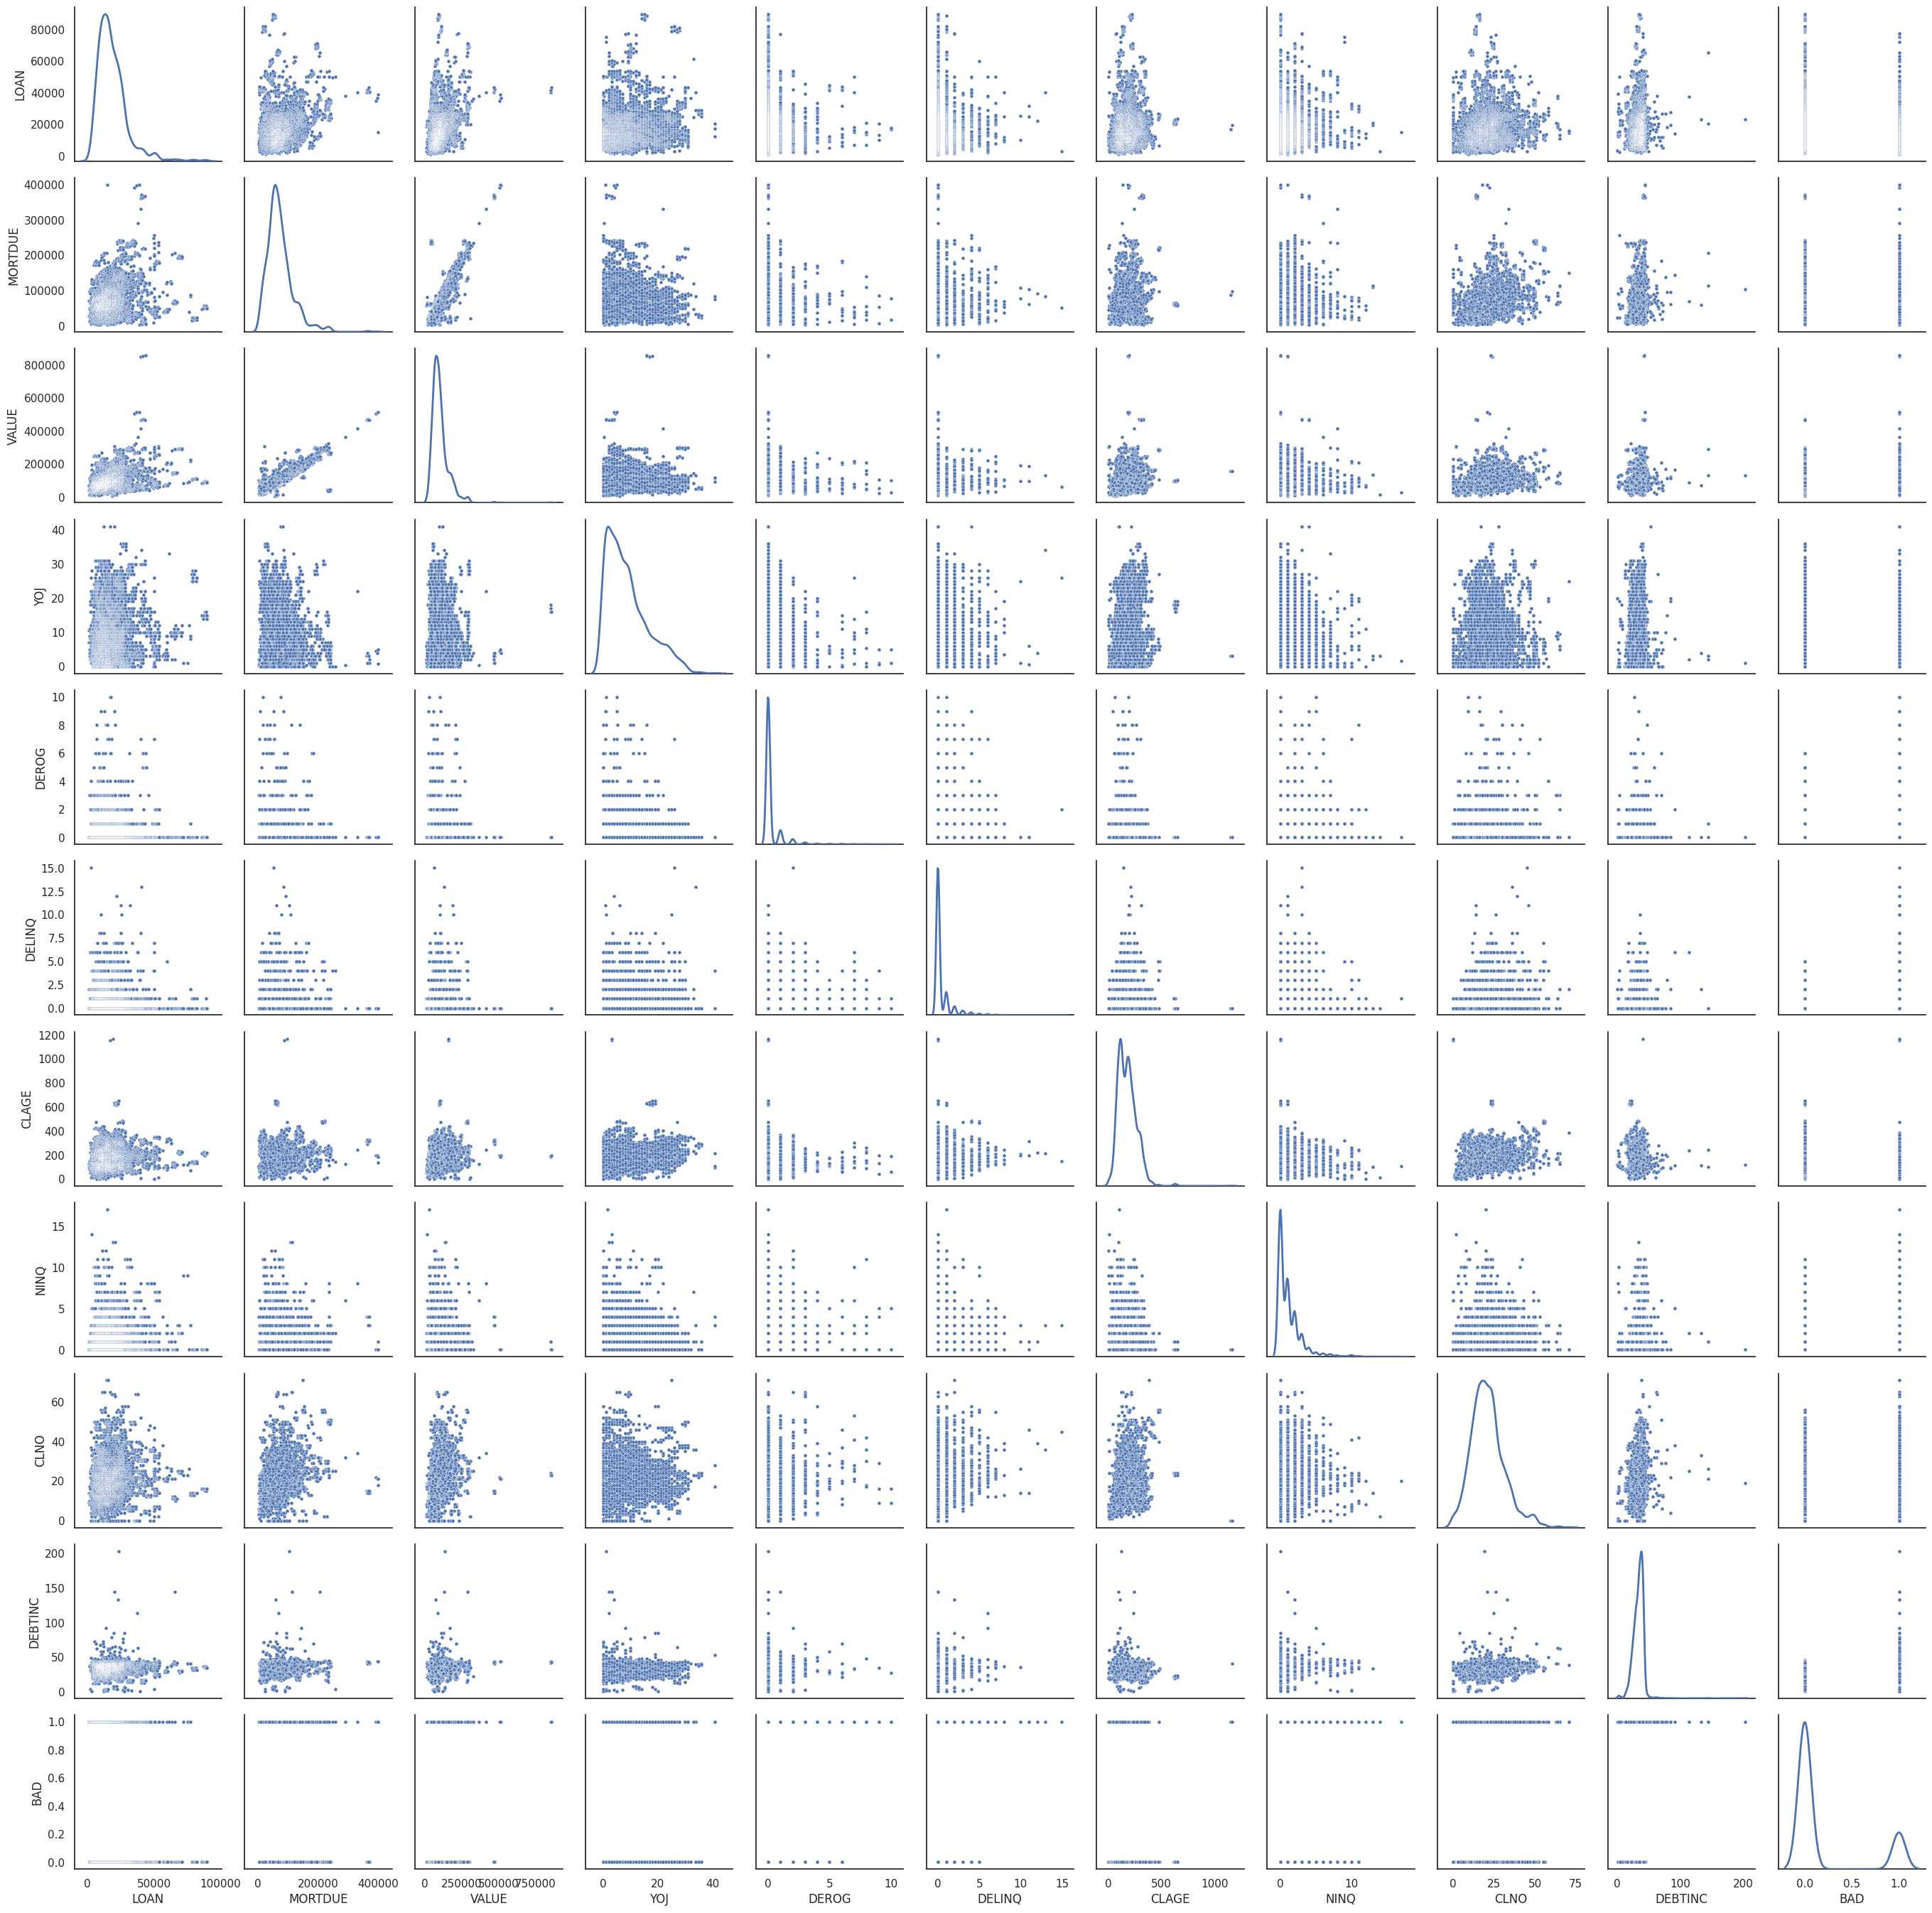

In [10]:
sns.set_theme(style="white")

g =sns.PairGrid(df[['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'BAD']], diag_sharey=False)
g.map_upper(sns.scatterplot, s=13)
g.map_lower(sns.scatterplot, s=13)
g.map_diag(sns.kdeplot, lw=2)

### Define inputs and predicted variable

In [10]:
X=df[['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']]
y=df[['BAD']]

### Cleanse and impute

In [11]:
kinds = np.array([dt.kind for dt in X.dtypes])
all_columns = X.columns.values
is_cat = kinds == 'O'
cat_cols = all_columns[is_cat==True]
num_cols = all_columns[is_cat==False]

In [12]:
cat_cols

array(['REASON', 'JOB'], dtype=object)

Impute categorical

In [13]:
imputer = SimpleImputer(strategy='constant', fill_value='MISSING')
imputer.fit(X[cat_cols])
X_cat = imputer.transform(X[cat_cols])

In [14]:
ohe = OneHotEncoder(categories='auto',sparse=False, handle_unknown='ignore')
encoded_features = ohe.fit_transform(X_cat)
feature_names = ohe.get_feature_names_out(cat_cols)
X_ohe = pd.DataFrame(encoded_features, columns=feature_names)

In [15]:
X_ohe

,REASON_DebtCon,REASON_HomeImp,REASON_MISSING,JOB_MISSING,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
595995,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
595996,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
595997,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
595998,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Impute numerical

In [16]:
imputer = SimpleImputer(strategy='mean')
imp_cols = imputer.fit_transform(X[num_cols])
num_col_names = imputer.get_feature_names_out(num_cols)
X_num = pd.DataFrame(imp_cols, columns=num_col_names)

In [17]:
X_num

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100.0,25860.0000,39025.000000,10.500000,0.00000,0.000000,94.366667,1.000000,9.000000,33.779915
1,1300.0,70053.0000,68400.000000,7.000000,0.00000,2.000000,121.833333,0.000000,14.000000,33.779915
2,1500.0,13500.0000,16700.000000,4.000000,0.00000,0.000000,149.466667,1.000000,10.000000,33.779915
3,1500.0,73760.8172,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915
4,1700.0,97800.0000,112000.000000,3.000000,0.00000,0.000000,93.333333,0.000000,14.000000,33.779915
...,...,...,...,...,...,...,...,...,...,...
595995,88900.0,57264.0000,90185.000000,16.000000,0.00000,0.000000,221.808718,0.000000,16.000000,36.112347
595996,89000.0,54576.0000,92937.000000,16.000000,0.00000,0.000000,208.692070,0.000000,15.000000,35.859971
595997,89200.0,54045.0000,92924.000000,15.000000,0.00000,0.000000,212.279697,0.000000,15.000000,35.556590
595998,89800.0,50370.0000,91861.000000,14.000000,0.00000,0.000000,213.892709,0.000000,16.000000,34.340882


### Merge data back together

In [18]:
X = pd.concat([X_num,X_ohe], axis =1)

In [19]:
X.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,REASON_MISSING,JOB_MISSING,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1100.0,25860.0000,39025.000000,10.500000,0.00000,0.000000,94.366667,1.000000,9.000000,33.779915,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1300.0,70053.0000,68400.000000,7.000000,0.00000,2.000000,121.833333,0.000000,14.000000,33.779915,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1500.0,13500.0000,16700.000000,4.000000,0.00000,0.000000,149.466667,1.000000,10.000000,33.779915,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1500.0,73760.8172,101776.048741,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1700.0,97800.0000,112000.000000,3.000000,0.00000,0.000000,93.333333,0.000000,14.000000,33.779915,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Train & test split

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=3)

Create an empty table for recording runtimes

In [21]:
training_times = pd.DataFrame()
training_times['SAS Viya']=0
training_times['SKLearn']=0
inference_times = training_times.copy()

### Train classification model with sklearn

In [22]:
#SKLearn Gradient Boosting
start = time.time()
sk_gbm_model = GradientBoostingClassifierSK(min_samples_leaf=5, n_estimators=100, max_depth=4, subsample=0.5)
sk_gbm_model.fit(X_train, y_train)
end = time.time()
training_times.loc['GBM', 'SKLearn']=end-start
start = time.time()
preds = sk_gbm_model.predict(X_test)
end = time.time()
inference_times.loc['GBM', 'SKLearn']=end-start
#print('F1 Score', round(100*f1_score(valid[target], preds),2))

In [24]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96    119261
           1       0.91      0.77      0.83     29739

    accuracy                           0.94    149000
   macro avg       0.93      0.88      0.90    149000
weighted avg       0.94      0.94      0.94    149000



### Train classification model with sasviya ml

In [25]:
#SAS Viya Gradient Boosting
start = time.time()
sas_gbm_model = GradientBoostingClassifier(min_samples_leaf=5, n_estimators=100, max_depth=4, subsample=0.5)
sas_gbm_model.fit(X_train, y_train)
end = time.time()
training_times.loc['GBM', 'SAS Viya']=end-start
start = time.time()
preds2 = sas_gbm_model.predict(X_test)
end = time.time()
inference_times.loc['GBM', 'SAS Viya']=end-start
#print('F1 Score', round(100*f1_score(valid[target], preds),2))

In [26]:
print(classification_report(y_test,preds2))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96    119261
           1       0.91      0.76      0.83     29739

    accuracy                           0.94    149000
   macro avg       0.92      0.87      0.89    149000
weighted avg       0.94      0.94      0.93    149000



In [27]:
preds2

20966     1
492326    0
352479    0
139756    0
118045    0
         ..
538213    0
172374    0
378953    0
176160    0
296256    0
Name: I_BAD, Length: 149000, dtype: int64

In [28]:
training_times.head()

,SAS Viya,SKLearn
GBM,2.86508,32.783299


### Test sasviya ml without onehotencoding and imputation

In [29]:
X2=df[['LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']]
y2=df[['BAD']]

In [30]:
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,test_size=0.25,random_state=3)

In [31]:
X2_train

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
92153,15500,38900.0,60500.0,DebtCon,Other,8.0,7.0,4.0,95.900000,2.0,53.0,NaN
75763,22100,60396.0,101741.0,DebtCon,Office,8.0,NaN,0.0,97.023226,1.0,17.0,35.681521
564020,20000,NaN,73800.0,DebtCon,Sales,4.0,0.0,0.0,404.766667,0.0,24.0,NaN
308434,23300,91957.0,135827.0,DebtCon,ProfExe,NaN,0.0,1.0,203.071688,0.0,20.0,27.833356
171995,27400,51298.0,90010.0,DebtCon,Other,6.0,1.0,0.0,146.656220,3.0,29.0,42.159937
...,...,...,...,...,...,...,...,...,...,...,...,...
535549,27300,140773.0,188414.0,DebtCon,ProfExe,12.0,0.0,0.0,144.093465,0.0,37.0,41.482804
366848,17500,46636.0,72908.0,DebtCon,Other,7.0,0.0,0.0,110.230907,3.0,15.0,41.512292
572344,5000,40000.0,32480.0,HomeImp,Other,8.0,3.0,2.0,163.366667,1.0,16.0,NaN
452227,28300,68959.0,102048.0,DebtCon,ProfExe,12.0,0.0,0.0,278.714704,1.0,32.0,39.932750


In [32]:
#SAS Viya Gradient Boosting PLAIN
start = time.time()
sas_gbmplain_model = GradientBoostingClassifier(min_samples_leaf=5, n_estimators=100, max_depth=4, subsample=0.5)
sas_gbmplain_model.fit(X2_train, y2_train)
end = time.time()
training_times.loc['GBM_plain', 'SAS Viya']=end-start
start = time.time()
preds_plain = sas_gbmplain_model.predict(X2_test)
end = time.time()
inference_times.loc['GBM_plain', 'SAS Viya']=end-start
#print('F1 Score', round(100*f1_score(valid[target], preds),2))

In [33]:
print(classification_report(y2_test,preds_plain))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96    119261
           1       0.90      0.79      0.84     29739

    accuracy                           0.94    149000
   macro avg       0.92      0.88      0.90    149000
weighted avg       0.94      0.94      0.94    149000



In [57]:
preds_plain

5919    1
4042    0
1636    0
1032    0
4741    1
       ..
4881    0
4611    0
611     1
4719    0
698     0
Name: I_BAD, Length: 1490, dtype: int64

In [35]:
training_times

,SAS Viya,SKLearn
GBM,2.86508,32.783299
GBM_plain,5.67979,NaN
